In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader


import copy
import time
import os
import sys
import random

c:\Users\berkidem\.conda\envs\DeepLearningEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
batch_size = 4096

In [4]:
# read the data from /input/train.csv
data = pd.read_csv("train.csv")

In [5]:
real_test_df = pd.read_csv('test.csv')

In [6]:
# split the data into train, validation and test sets
train_df, test_df = train_test_split(
    data, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(
    train_df, test_size=0.25, random_state=42)

In [7]:
train_df.shape

(70538, 10)

In [8]:
cols2use = train_df.columns.tolist()
cols2use.remove('id')
cols2use.remove('Class')

In [9]:
cols2use

['Mean_Integrated',
 'SD',
 'EK',
 'Skewness',
 'Mean_DMSNR_Curve',
 'SD_DMSNR_Curve',
 'EK_DMSNR_Curve',
 'Skewness_DMSNR_Curve']

In [10]:
class PulsarDataset(Dataset):

    def __init__(self, df, feature_columns=cols2use, with_labels=True):
        
        self.with_labels = with_labels
        self.ids = df.id.values
        
        #FEATURES
        self.features = df[feature_columns].values
        
        # LABELS
        if with_labels:
            self.labels = df.Class.values

    
    def __len__(self):
        return len(self.ids)
        
    def __getitem__(self, idx):

        ids = self.ids[idx]
        features = self.features[idx]
        
        targets = ''
        if self.with_labels:
            targets = self.labels[idx]
            sample = {'ids':ids,'features':features,'targets':targets}
        else:
            sample = {'ids':ids,'features':features}
       
        
        return sample

In [11]:
dataframes = {}

for phase in ['train', 'test', 'val', 'real_test']:
    dataframes[phase] = df=locals()[phase+'_df']

In [12]:
datasets = {}
dataloaders = {}
for split in ['train','val','test', 'real_test']: 
    shuffle = False
    with_labels = True
    if split=="train":
        shuffle = True
    if split=="real_test":
        with_labels = False
    datasets[split] =  PulsarDataset(df=dataframes[split], with_labels=with_labels)

    dataloaders[split] = DataLoader(datasets[split], batch_size=batch_size,
                              shuffle=shuffle)

In [13]:
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val','test', 'real_test']}
dataset_sizes

{'train': 70538, 'val': 23513, 'test': 23513, 'real_test': 78377}

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, l1_weight, l2_weight, optimizer, scheduler, num_epochs=1,model_filename=''):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100000000000000
    iters = []
    training_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print('-' * 10)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))

        iters.append(epoch)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for output in dataloaders[phase]:
                features = output['features'].float()
                targets = output['targets']
                targets = torch.reshape(targets, (targets.size(0), 1))
                features = features.to(device)
                targets = targets.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                outputs = model(features)
            
                targets = torch.flatten(targets)
                
                loss = criterion(outputs, targets)
                loss = loss.to(device)
                
#                 l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
#                 l1_penalty = l1_penalty.to(device)
#                 l2_penalty = l2_weight * sum([(p**2).sum() for p in model.parameters()])
#                 l2_penalty = l2_penalty.to(device)
#                 loss += l1_penalty + l2_penalty
                
                if phase == 'train':
                    scheduler.step()
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * targets.size(0)
                
                


            epoch_loss = running_loss / dataset_sizes[phase]
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print('PASSED')
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Performance on test_set')
                eval_model(model,criterion, l1_weight, l2_weight, optimizer)
                if model_filename!='':
                    torch.save(model.state_dict(), os.path.join(model_filename))
                    
            if phase == 'train':
                training_losses.append(epoch_loss)
            elif phase == 'val':
                val_losses.append(epoch_loss)

        plt.plot(iters, training_losses, label='training loss')
        plt.plot(iters, val_losses, label='validation loss')
        plt.xlabel("Epoch")
        plt.ylabel("Losses")
        plt.legend(loc='best')
        plt.show()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def eval_model(model, criterion, l1_weight, l2_weight, optimizer):
    since = time.time()
    phase = 'test'
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0

    
    # Iterate over data.
    predictions = []
    tars = []
    for output in dataloaders[phase]:
        features = output['features'].float()
        targets = output['targets']
        targets = torch.reshape(targets, (targets.size(0), 1))
        features = features.to(device)
        targets = targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()



        with torch.no_grad():
            outputs = model(features)


            targets = torch.flatten(targets)
            loss = criterion(outputs, targets)
            loss = loss.to(device)            
            
#             l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
#             l1_penalty = l1_penalty.to(device)
#             l2_penalty = l2_weight * sum([(p**2).sum() for p in model.parameters()])
#             l2_penalty = l2_penalty.to(device)
#             loss += l1_penalty + l2_penalty
            
        # statistics
        running_loss += loss.item() * targets.size(0)
        

    eval_loss = running_loss / dataset_sizes[phase]

    
    time_elapsed = time.time() - since
    print('Evaluation Loss: {:.4f}'.format(eval_loss))
    
    return eval_loss

In [16]:
def predict(model, criterion, l1_weight, l2_weight, optimizer, phase):
    
    since = time.time()
    model.eval()   # Set model to evaluate mode
    
    # Iterate over data.
    
    count =0
    

    names = []
    predictions = []
    tars = []

    for output in dataloaders[phase]:
        ids = output['ids']
        features = output['features'].float()
        features = features.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()



        with torch.no_grad():
            outputs = model(features)
            
            outputs =  outputs.squeeze()
            outputs.size()
            
            if count == 0:

                predictions = np.array([np.array(outputs[:,0]), np.array(outputs[:,1]), np.array(ids)])
            else:
                predictions = np.append(predictions, [np.array(outputs[:,0]), np.array(outputs[:,1]), np.array(ids)], axis=1)
            count += 1

    time_elapsed = time.time() - since
    
    # transpose predictions
    preds = predictions.transpose(1,0)

    # get unnormalized probabilities
    unnormalized_probs = preds[:,0:2]

    # normalize probabilities
    SM = nn.Softmax(dim=1)
    normalized_probs = np.array(SM(torch.tensor(unnormalized_probs)).detach().numpy())

    # make a dataframe with the unnormalized probabilities and the preds
    preds = preds[:,2]
    pred_df = pd.DataFrame(np.concatenate((preds.reshape(-1,1), normalized_probs), axis=1), columns=['id', 'prob_1', 'prob_2'])

    # drop one of the probabilities
    pred_df.drop('prob_1', axis=1, inplace=True)

    # rename the other probability column
    pred_df.rename(columns={'prob_2': 'Class'}, inplace=True)

    # convert the id column to int
    pred_df['id'] = pred_df['id'].astype(int)

    #pred_df = pd.DataFrame(predictions.transpose(1,0), columns=['prob_1', 'prob_2', 'ids'])
    return pred_df


In [21]:
# tweaked version of autogluon's tabular model

class aglModel(nn.Module):
    
    def __init__(self, num_nodes=100):
        super(aglModel, self).__init__()
                
        self.final = torch.nn.Sequential(
        #torch.nn.Dropout(p=0.1, inplace=False),
        torch.nn.BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        torch.nn.Linear(8, 512, bias = False),
        # torch.nn.BatchNorm1d(512),
        torch.nn.ReLU(inplace=True),
        torch.nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        torch.nn.Dropout(p=0.3, inplace=False),
        torch.nn.Linear(in_features=512, out_features=128, bias=False),
        torch.nn.ReLU(inplace=True),
        torch.nn.BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        #torch.nn.Dropout(p=0.1, inplace=False),
        torch.nn.Linear(in_features=128, out_features=2, bias=True)
        )

        
    def forward(self, features):
        all_features = features
        final_out = self.final(all_features)
        return final_out

In [ ]:
class myModel(nn.Module):
    
    def __init__(self, num_nodes=100):
        super(myModel, self).__init__()
                
        self.final = torch.nn.Sequential(
        torch.nn.Linear(8, 512, bias = False),
        torch.nn.BatchNorm1d(512),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.3, inplace=False),
        torch.nn.Linear(512, 256, bias = False),
        torch.nn.BatchNorm1d(256),
        torch.nn.ReLU(),
        #torch.nn.Dropout(p=0.1, inplace=False),
        torch.nn.Linear(256, 128, bias = True),
        torch.nn.BatchNorm1d(128),
        torch.nn.ReLU(),
        # torch.nn.Dropout(p=0.1, inplace=False),
        # #torch.nn.Linear(128, 64, bias = False),
        # #torch.nn.ReLU(),
        # #torch.nn.BatchNorm1d(num_nodes),
        # #torch.nn.Linear(64, 1, bias=True)
        # #torch.nn.ReLU(),
        torch.nn.Linear(128, 2, bias=True),
        # torch.nn.Softmax()
        )

        
    def forward(self, features):
        all_features = features
        final_out = self.final(all_features)
        return final_out

In [18]:
model = myModel(64)
model = model.to(device)

In [19]:
criterion = torch.nn.CrossEntropyLoss()

In [20]:
# Observe that all parameters are being optimized

#optimizer = torch.optim.SGD(model.parameters(), lr=0.0000008, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters())
#optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

l1_weight = 0e-4
l2_weight = 0e-4

In [138]:
# one cycle LR

epochs = 100

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.008, steps_per_epoch=len(dataloaders['train']), three_phase = False, epochs=epochs)

----------
Epoch 1/100


c:\Users\berkidem\.conda\envs\DeepLearningEnv\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.3088
val Loss: 0.2897
PASSED
Performance on test_set
Evaluation Loss: 0.2889


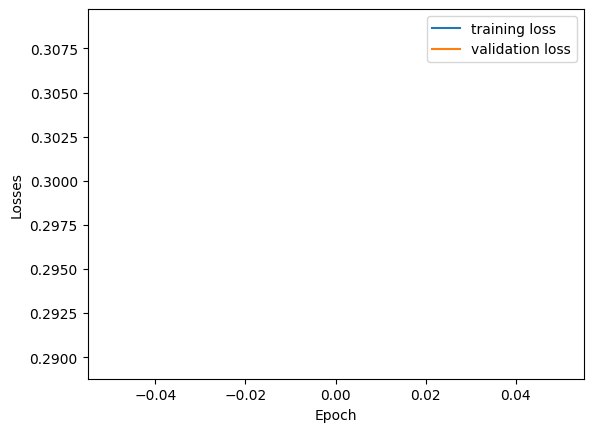

----------
Epoch 2/100
train Loss: 0.1822
val Loss: 0.1589
PASSED
Performance on test_set
Evaluation Loss: 0.1581


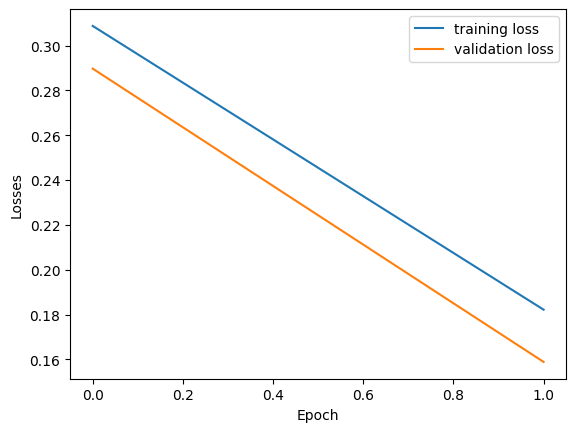

----------
Epoch 3/100
train Loss: 0.1378
val Loss: 0.1170
PASSED
Performance on test_set
Evaluation Loss: 0.1163


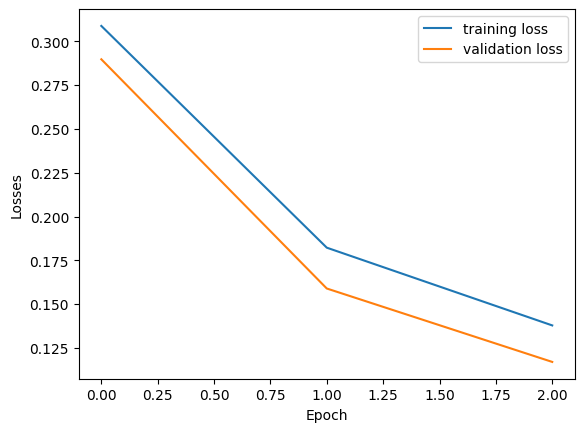

----------
Epoch 4/100
train Loss: 0.1070
val Loss: 0.0882
PASSED
Performance on test_set
Evaluation Loss: 0.0875


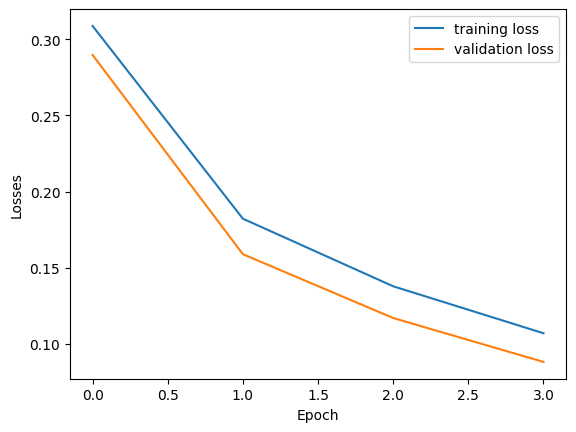

----------
Epoch 5/100
train Loss: 0.0841
val Loss: 0.0688
PASSED
Performance on test_set
Evaluation Loss: 0.0683


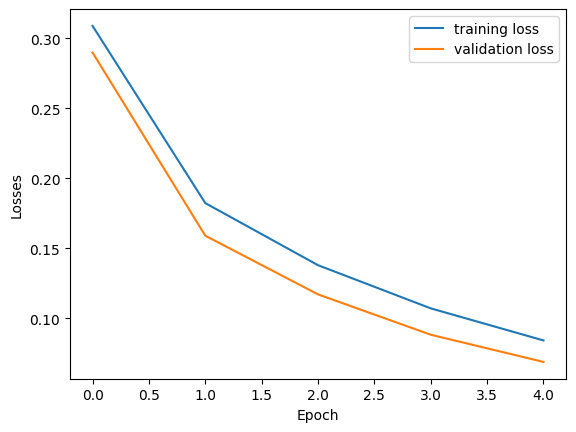

----------
Epoch 6/100
train Loss: 0.0679
val Loss: 0.0589
PASSED
Performance on test_set
Evaluation Loss: 0.0587


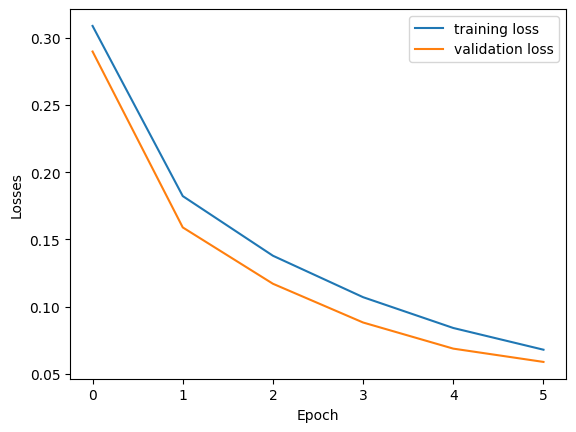

----------
Epoch 7/100
train Loss: 0.0574
val Loss: 0.0511
PASSED
Performance on test_set
Evaluation Loss: 0.0509


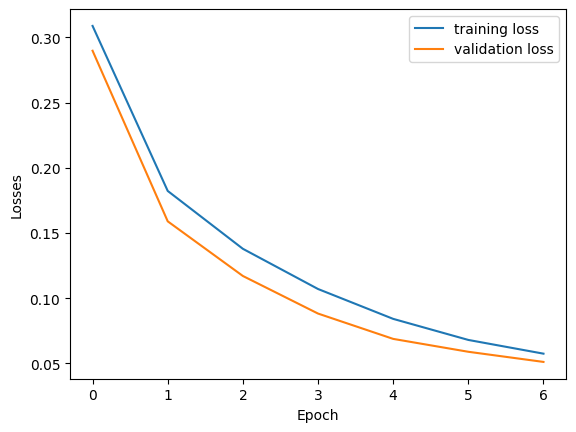

----------
Epoch 8/100
train Loss: 0.0508
val Loss: 0.0457
PASSED
Performance on test_set
Evaluation Loss: 0.0460


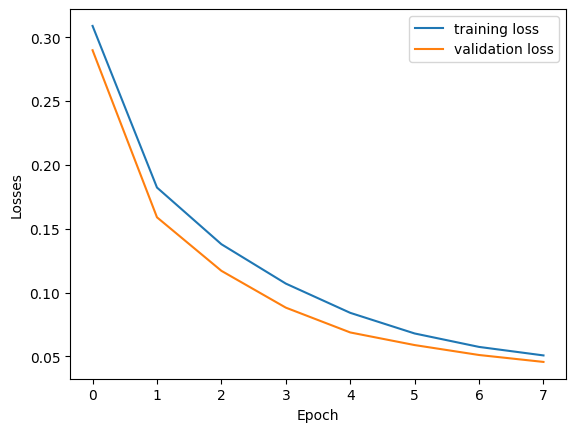

----------
Epoch 9/100
train Loss: 0.0470
val Loss: 0.0429
PASSED
Performance on test_set
Evaluation Loss: 0.0432


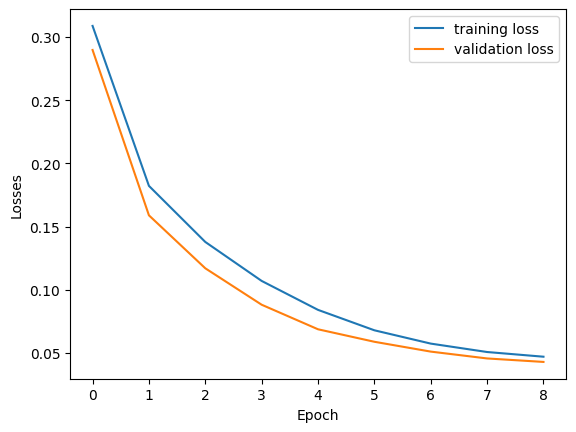

----------
Epoch 10/100
train Loss: 0.0446
val Loss: 0.0406
PASSED
Performance on test_set
Evaluation Loss: 0.0412


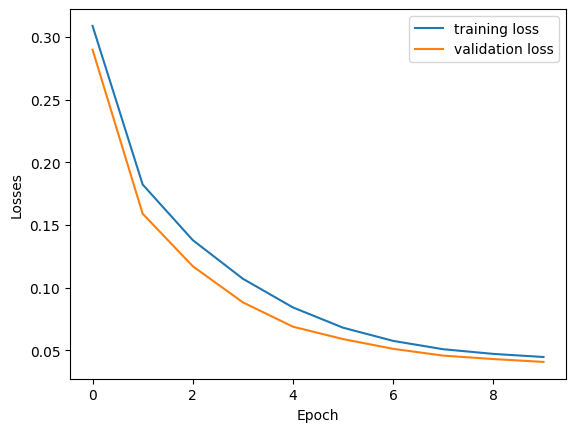

----------
Epoch 11/100
train Loss: 0.0432
val Loss: 0.0391
PASSED
Performance on test_set
Evaluation Loss: 0.0398


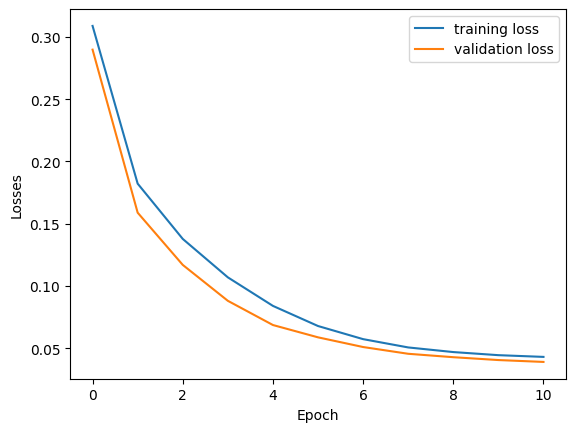

----------
Epoch 12/100
train Loss: 0.0428
val Loss: 0.0403


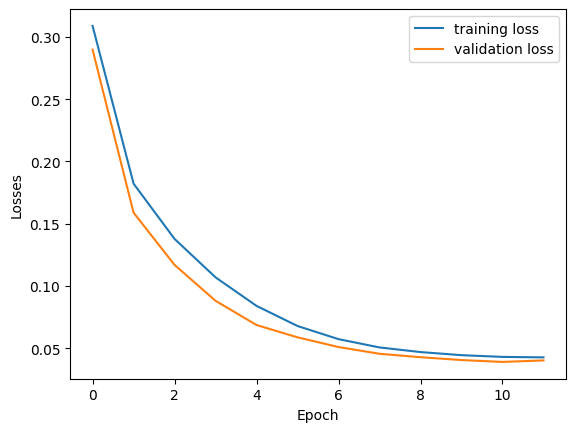

----------
Epoch 13/100
train Loss: 0.0406
val Loss: 0.0462


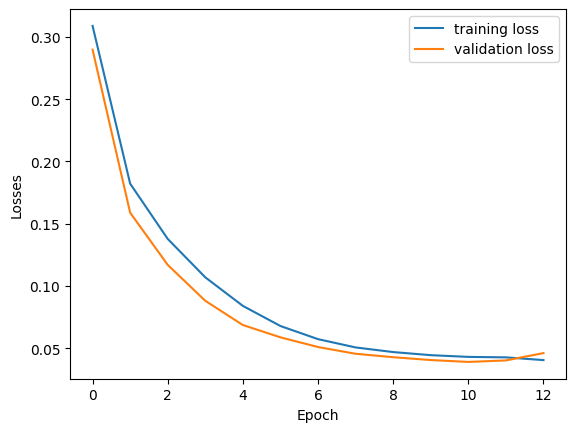

----------
Epoch 14/100
train Loss: 0.0409
val Loss: 0.0379
PASSED
Performance on test_set
Evaluation Loss: 0.0387


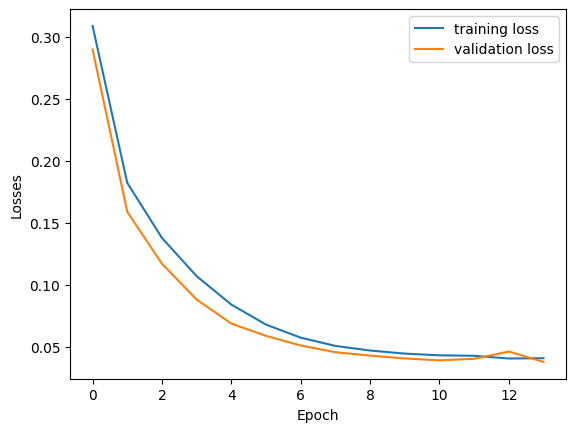

----------
Epoch 15/100
train Loss: 0.0395
val Loss: 0.0361
PASSED
Performance on test_set
Evaluation Loss: 0.0378


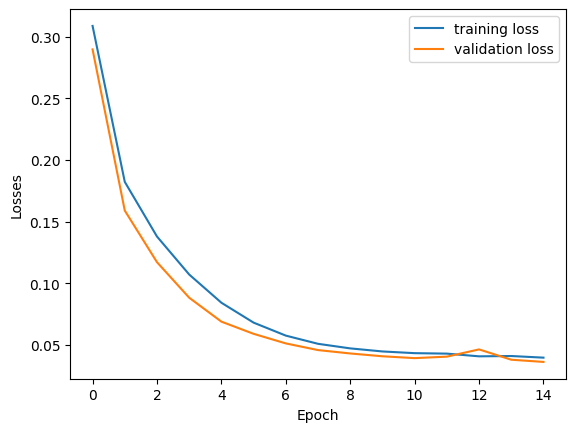

----------
Epoch 16/100
train Loss: 0.0396
val Loss: 0.0362


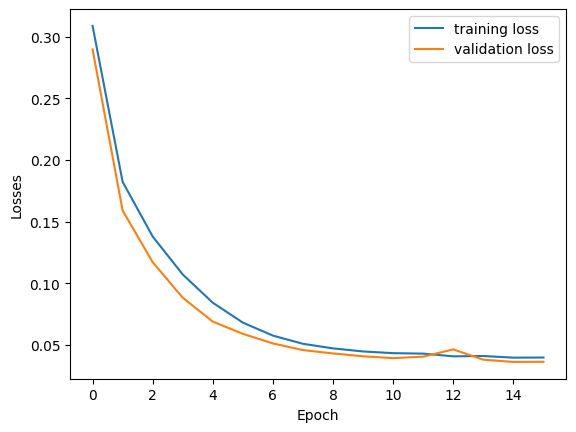

----------
Epoch 17/100
train Loss: 0.0385
val Loss: 0.0356
PASSED
Performance on test_set
Evaluation Loss: 0.0374


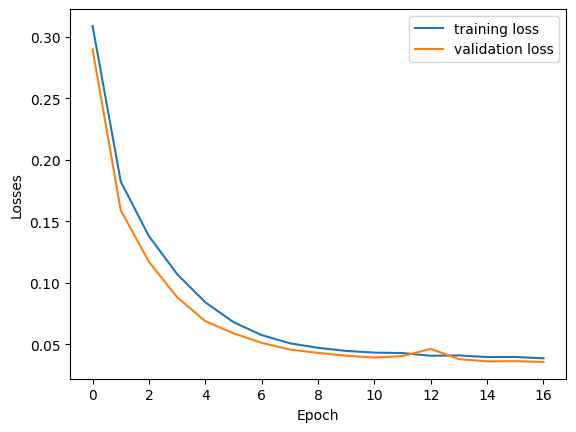

----------
Epoch 18/100
train Loss: 0.0376
val Loss: 0.0365


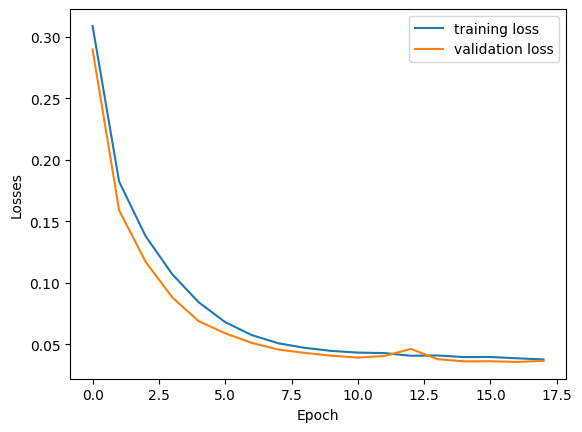

----------
Epoch 19/100
train Loss: 0.0378
val Loss: 0.0405


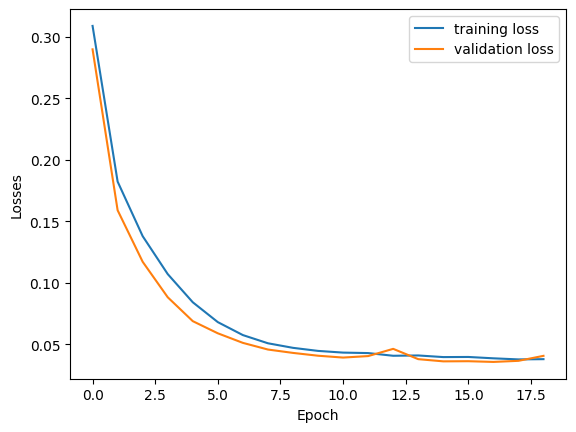

----------
Epoch 20/100
train Loss: 0.0376
val Loss: 0.0373


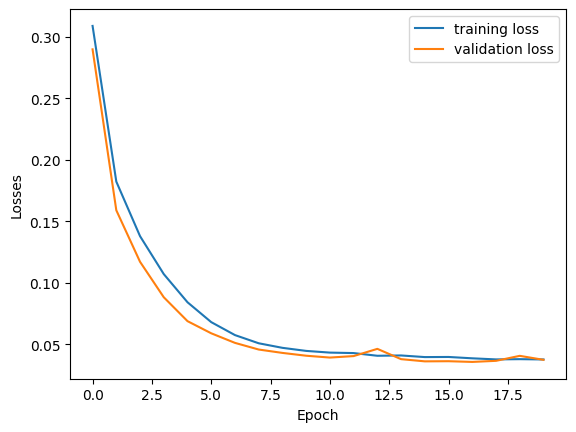

----------
Epoch 21/100
train Loss: 0.0372
val Loss: 0.0349
PASSED
Performance on test_set
Evaluation Loss: 0.0372


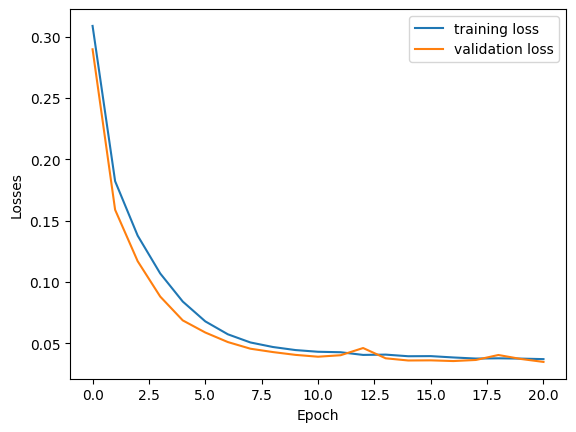

----------
Epoch 22/100
train Loss: 0.0372
val Loss: 0.0336
PASSED
Performance on test_set
Evaluation Loss: 0.0355


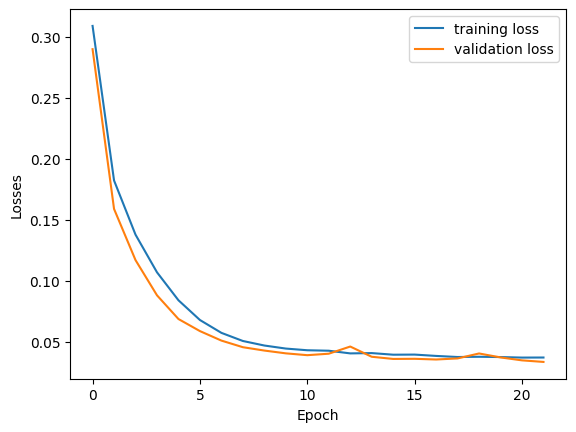

----------
Epoch 23/100
train Loss: 0.0372
val Loss: 0.0352


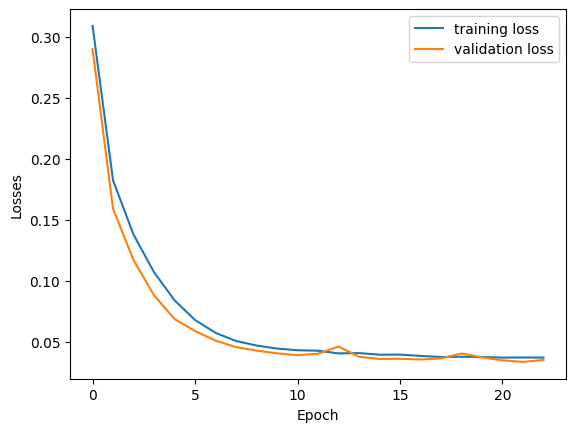

----------
Epoch 24/100
train Loss: 0.0367
val Loss: 0.0334
PASSED
Performance on test_set
Evaluation Loss: 0.0360


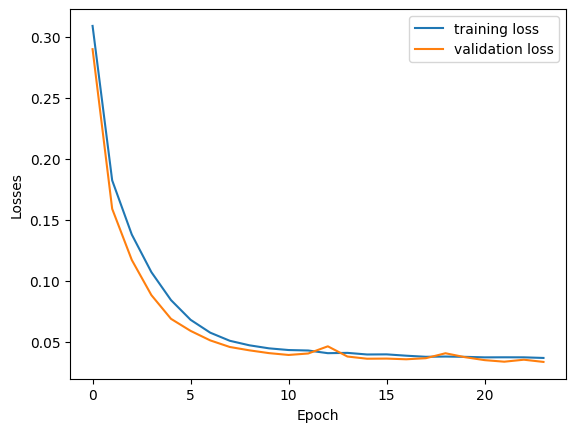

----------
Epoch 25/100
train Loss: 0.0360
val Loss: 0.0335


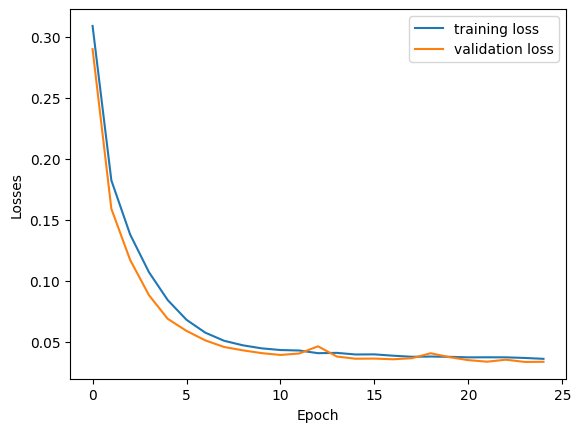

----------
Epoch 26/100
train Loss: 0.0360
val Loss: 0.0331
PASSED
Performance on test_set
Evaluation Loss: 0.0353


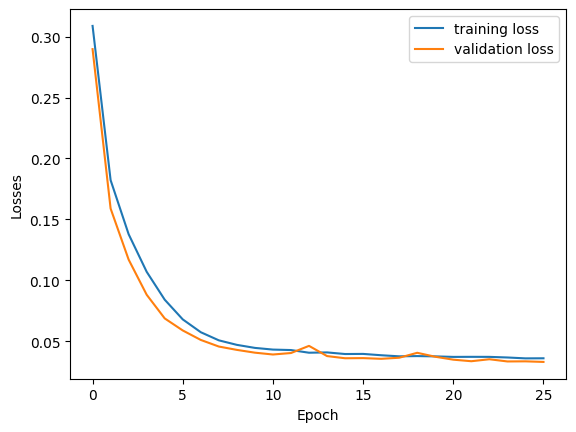

----------
Epoch 27/100
train Loss: 0.0357
val Loss: 0.0358


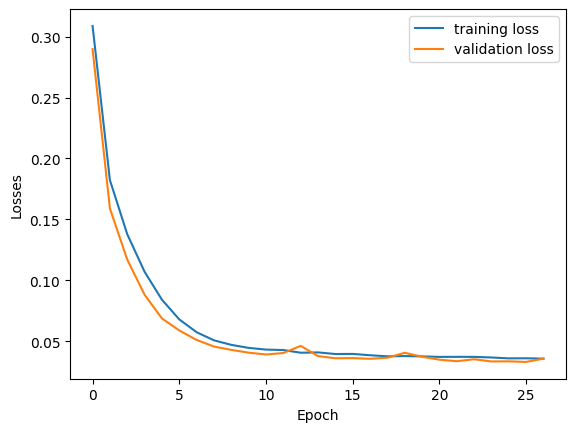

----------
Epoch 28/100
train Loss: 0.0367
val Loss: 0.0381


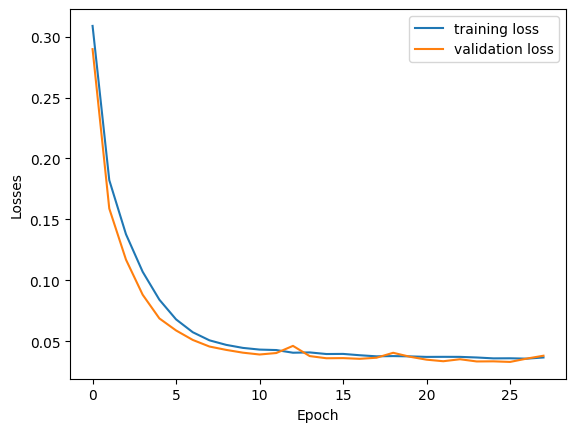

----------
Epoch 29/100
train Loss: 0.0357
val Loss: 0.0327
PASSED
Performance on test_set
Evaluation Loss: 0.0348


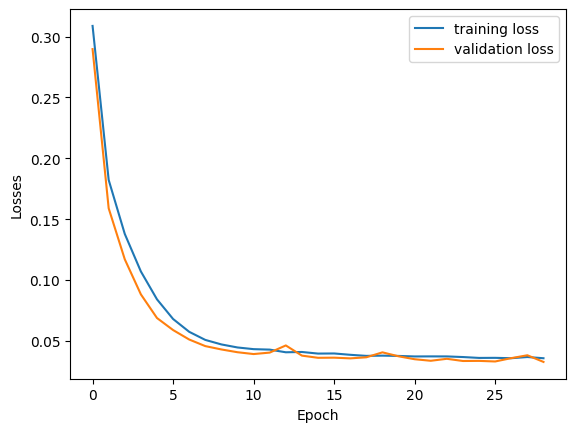

----------
Epoch 30/100
train Loss: 0.0356
val Loss: 0.0326
PASSED
Performance on test_set
Evaluation Loss: 0.0344


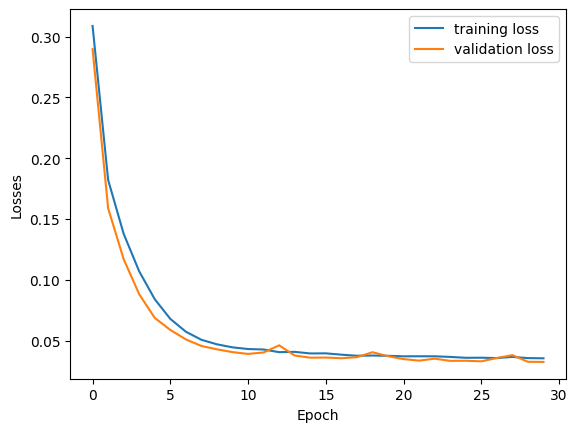

----------
Epoch 31/100
train Loss: 0.0351
val Loss: 0.0341


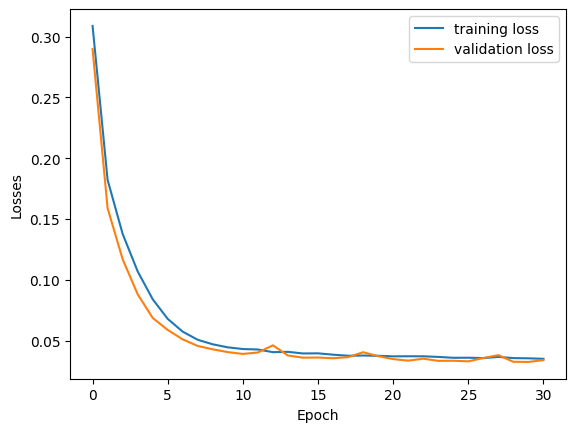

----------
Epoch 32/100
train Loss: 0.0344
val Loss: 0.0346


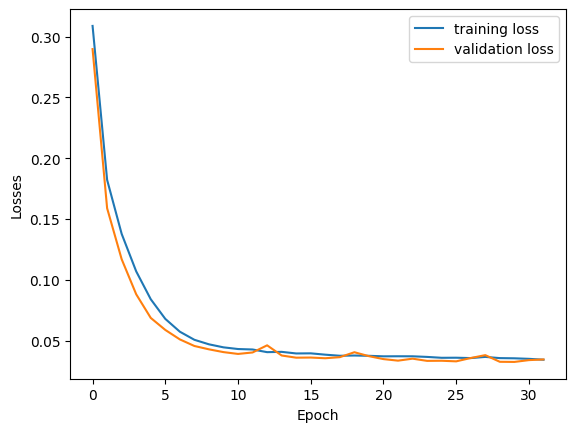

----------
Epoch 33/100
train Loss: 0.0351
val Loss: 0.0355


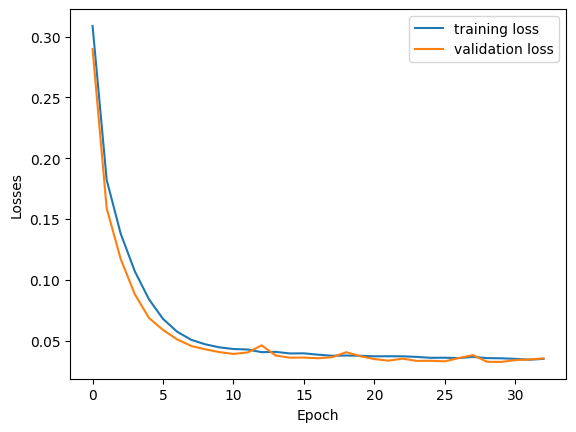

----------
Epoch 34/100
train Loss: 0.0344
val Loss: 0.0327


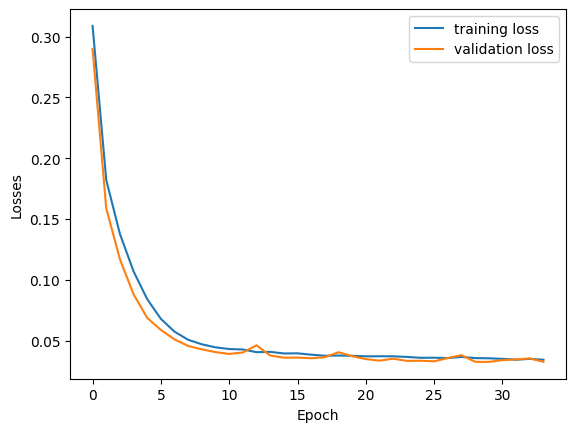

----------
Epoch 35/100
train Loss: 0.0341
val Loss: 0.0449


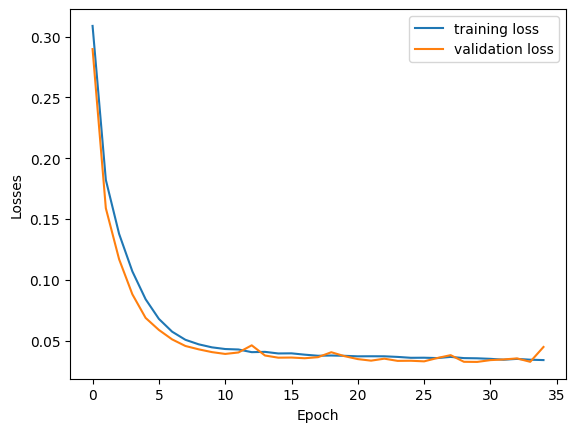

----------
Epoch 36/100
train Loss: 0.0356
val Loss: 0.0338


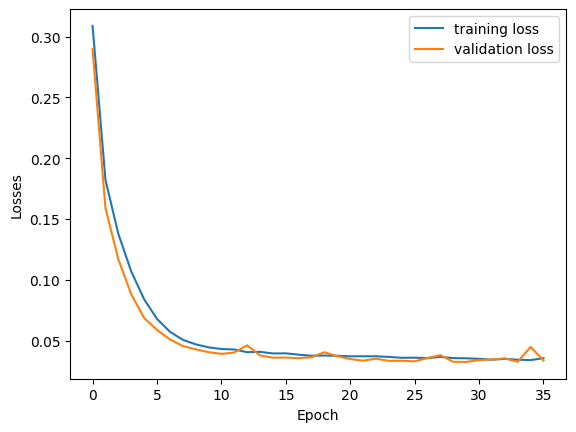

----------
Epoch 37/100
train Loss: 0.0342
val Loss: 0.0322
PASSED
Performance on test_set
Evaluation Loss: 0.0346


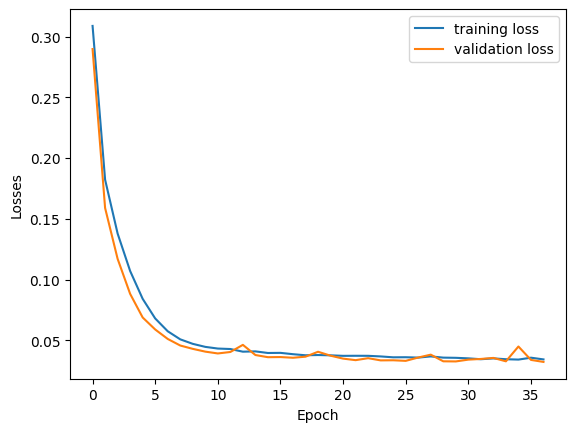

----------
Epoch 38/100
train Loss: 0.0336
val Loss: 0.0325


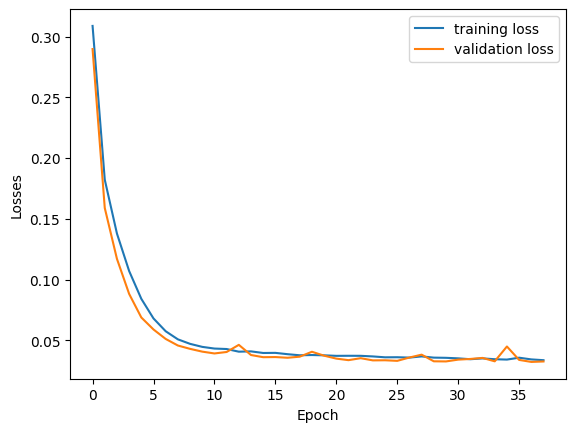

----------
Epoch 39/100
train Loss: 0.0348
val Loss: 0.0346


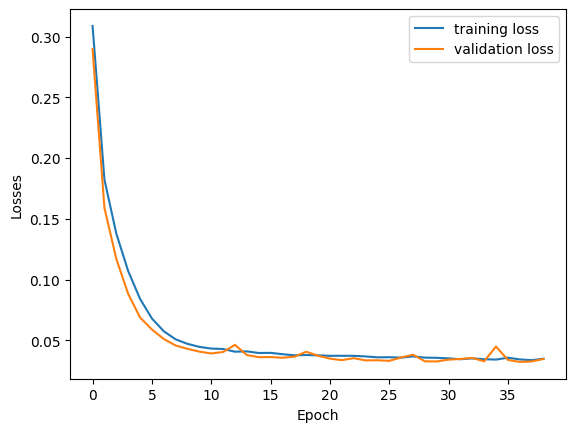

----------
Epoch 40/100
train Loss: 0.0351
val Loss: 0.0354


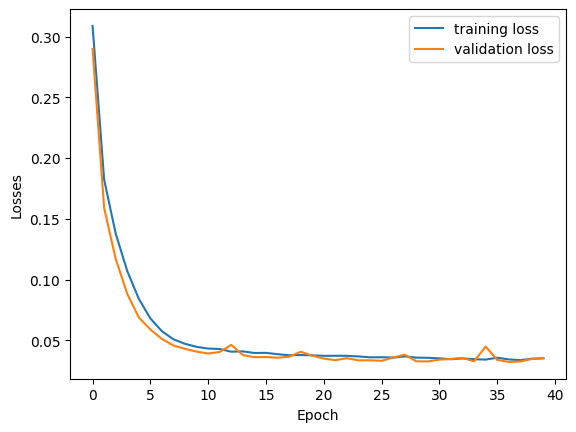

----------
Epoch 41/100
train Loss: 0.0342
val Loss: 0.0316
PASSED
Performance on test_set
Evaluation Loss: 0.0348


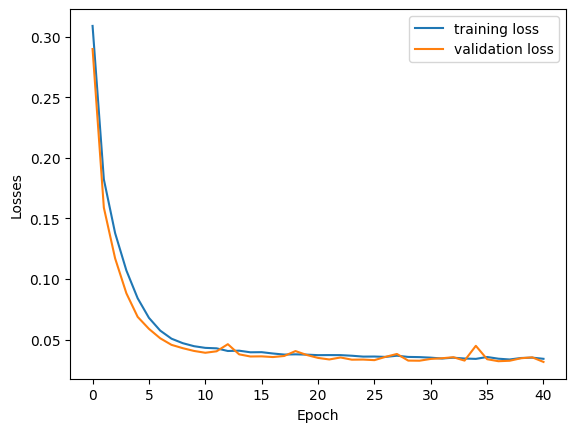

----------
Epoch 42/100
train Loss: 0.0340
val Loss: 0.0322


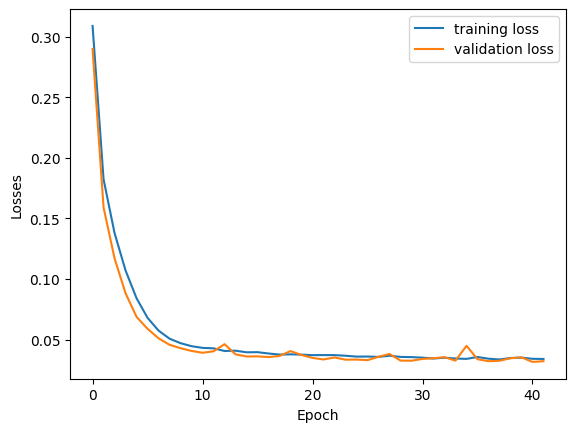

----------
Epoch 43/100
train Loss: 0.0335
val Loss: 0.0328


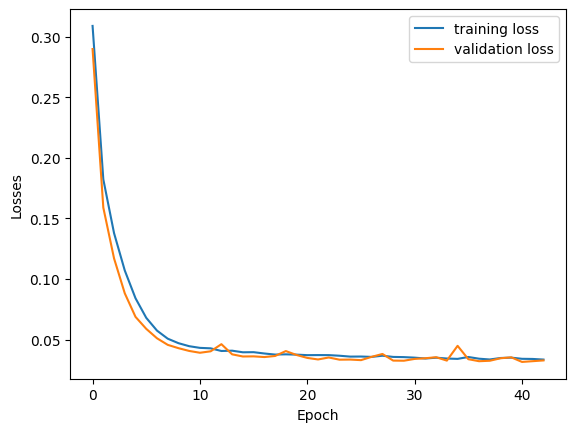

----------
Epoch 44/100
train Loss: 0.0342
val Loss: 0.0366


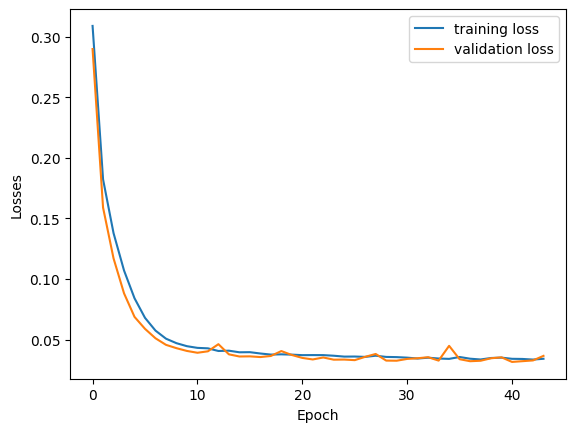

----------
Epoch 45/100
train Loss: 0.0339
val Loss: 0.0317


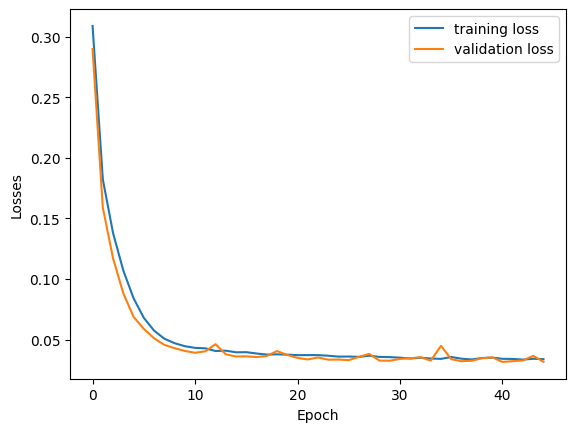

----------
Epoch 46/100
train Loss: 0.0333
val Loss: 0.0355


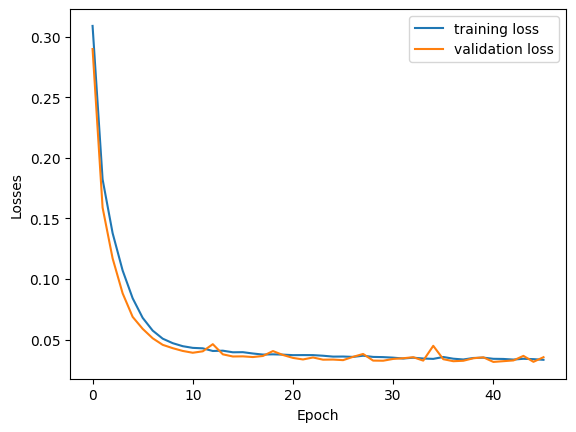

----------
Epoch 47/100
train Loss: 0.0337
val Loss: 0.0321


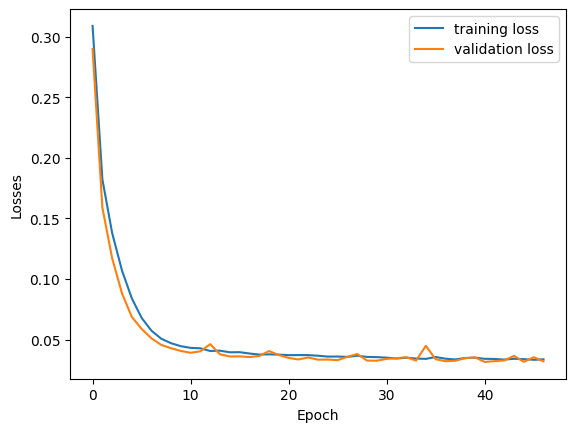

----------
Epoch 48/100
train Loss: 0.0334
val Loss: 0.0318


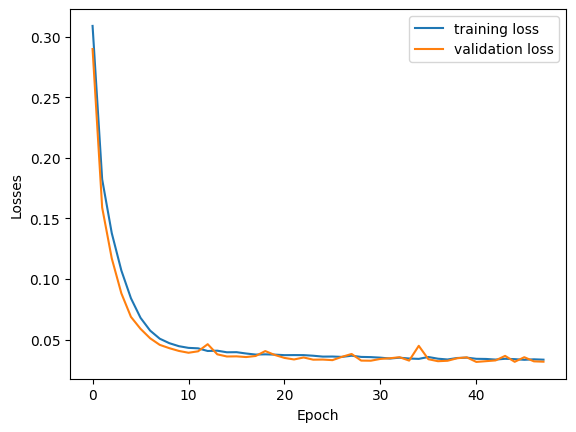

----------
Epoch 49/100
train Loss: 0.0327
val Loss: 0.0333


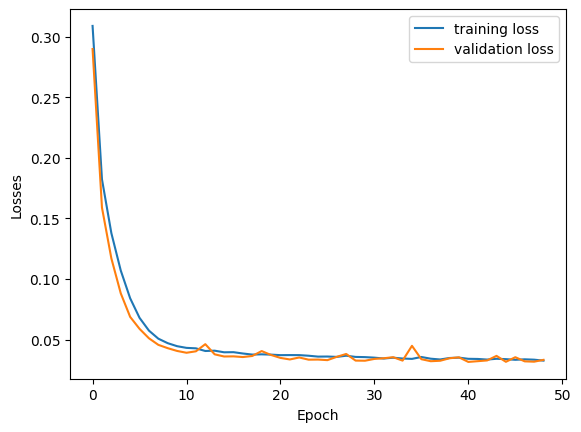

----------
Epoch 50/100
train Loss: 0.0332
val Loss: 0.0325


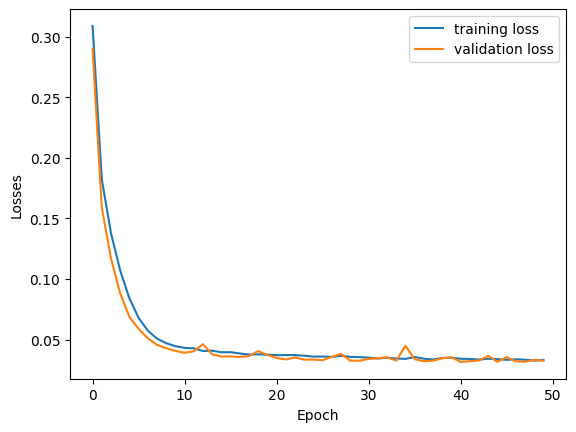

----------
Epoch 51/100
train Loss: 0.0332
val Loss: 0.0317


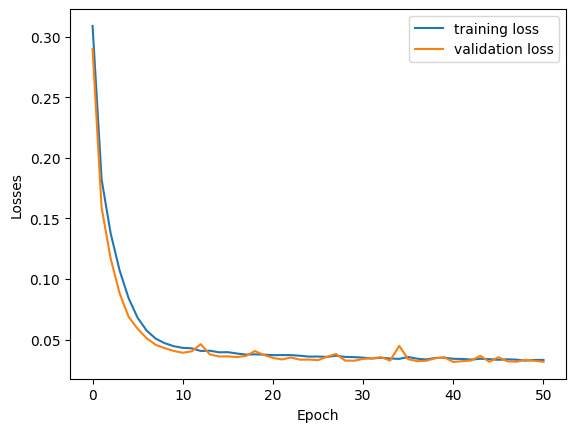

----------
Epoch 52/100
train Loss: 0.0333
val Loss: 0.0321


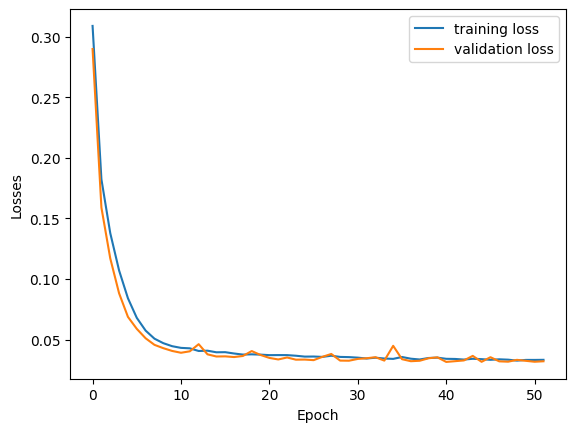

----------
Epoch 53/100
train Loss: 0.0331
val Loss: 0.0316
PASSED
Performance on test_set
Evaluation Loss: 0.0345


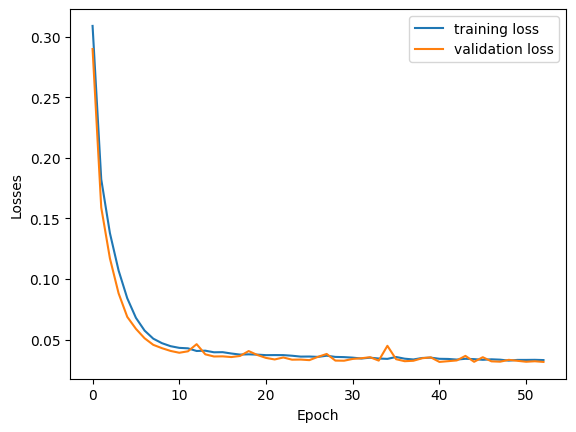

----------
Epoch 54/100
train Loss: 0.0331
val Loss: 0.0328


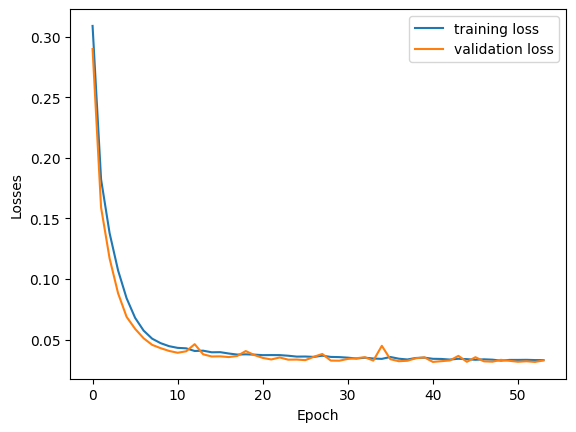

----------
Epoch 55/100
train Loss: 0.0323
val Loss: 0.0322


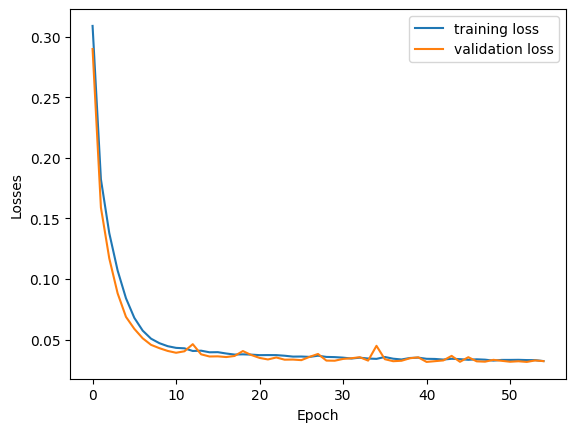

----------
Epoch 56/100
train Loss: 0.0329
val Loss: 0.0323


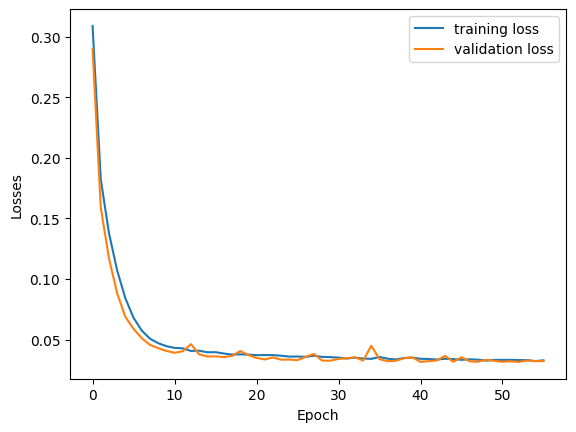

----------
Epoch 57/100
train Loss: 0.0329
val Loss: 0.0347


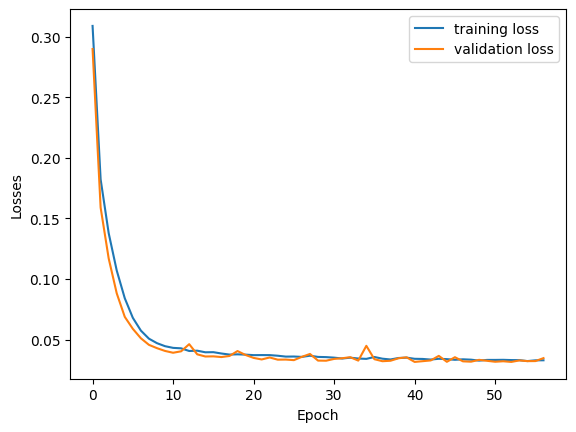

----------
Epoch 58/100
train Loss: 0.0328
val Loss: 0.0329


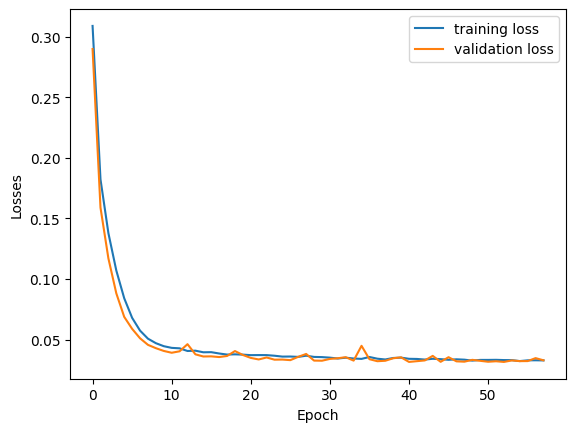

----------
Epoch 59/100
train Loss: 0.0326
val Loss: 0.0308
PASSED
Performance on test_set
Evaluation Loss: 0.0332


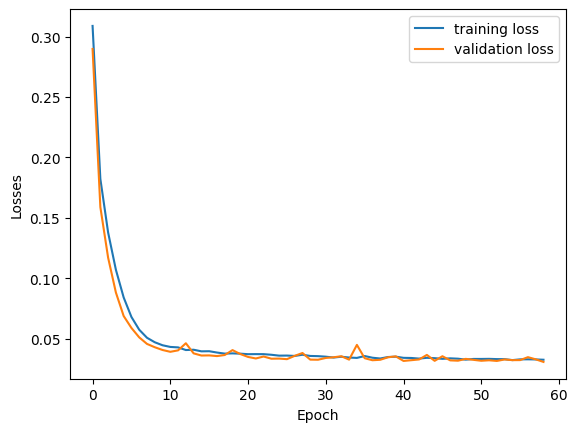

----------
Epoch 60/100
train Loss: 0.0329
val Loss: 0.0313


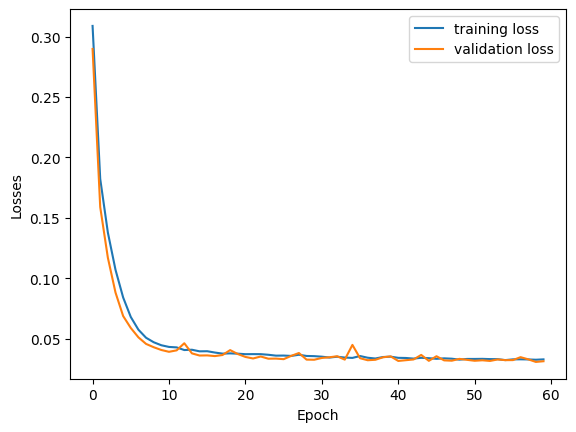

----------
Epoch 61/100
train Loss: 0.0322
val Loss: 0.0310


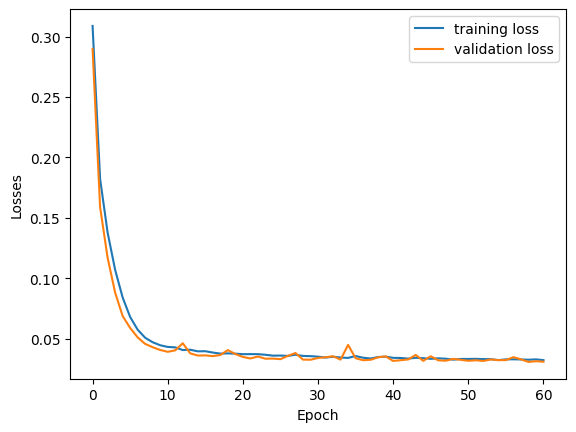

----------
Epoch 62/100
train Loss: 0.0323
val Loss: 0.0315


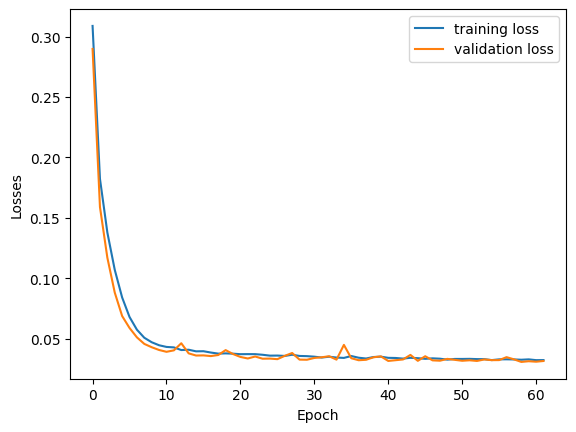

----------
Epoch 63/100
train Loss: 0.0322
val Loss: 0.0314


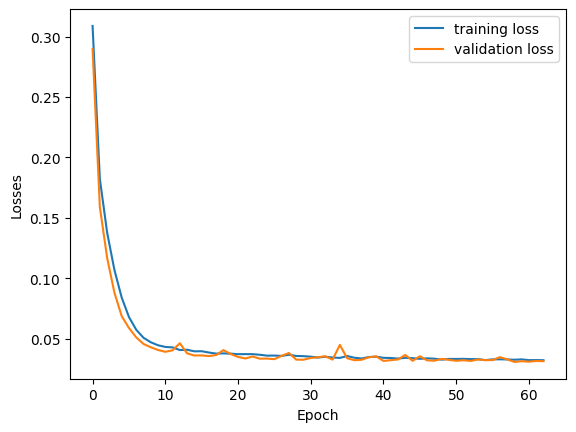

----------
Epoch 64/100
train Loss: 0.0318
val Loss: 0.0314


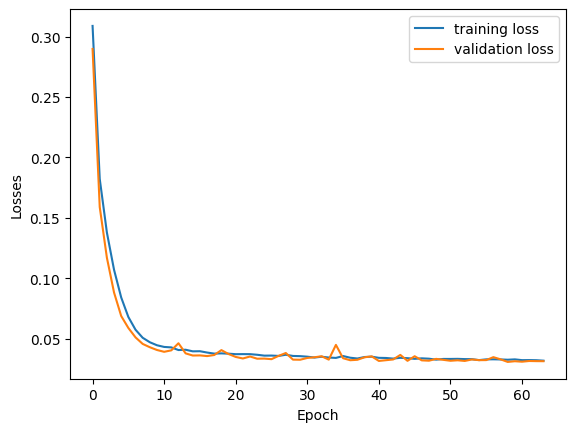

----------
Epoch 65/100
train Loss: 0.0318
val Loss: 0.0322


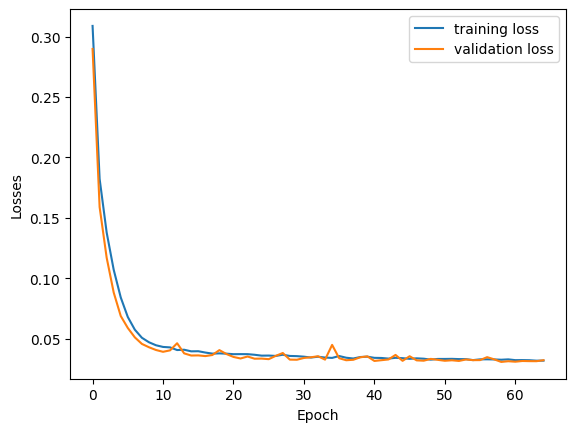

----------
Epoch 66/100
train Loss: 0.0316
val Loss: 0.0308


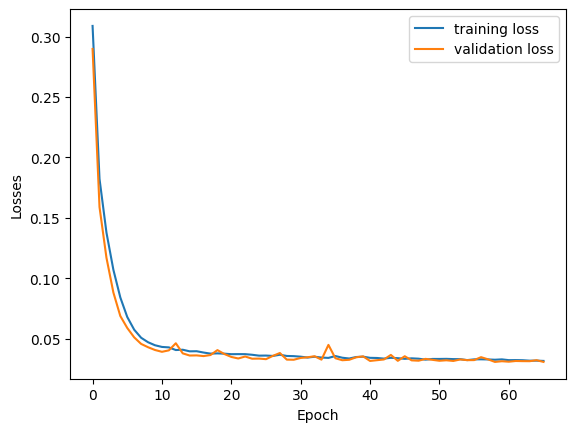

----------
Epoch 67/100
train Loss: 0.0317
val Loss: 0.0324


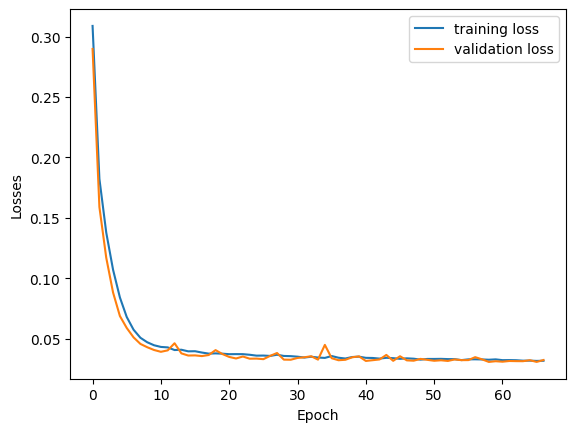

----------
Epoch 68/100
train Loss: 0.0320
val Loss: 0.0307
PASSED
Performance on test_set
Evaluation Loss: 0.0332


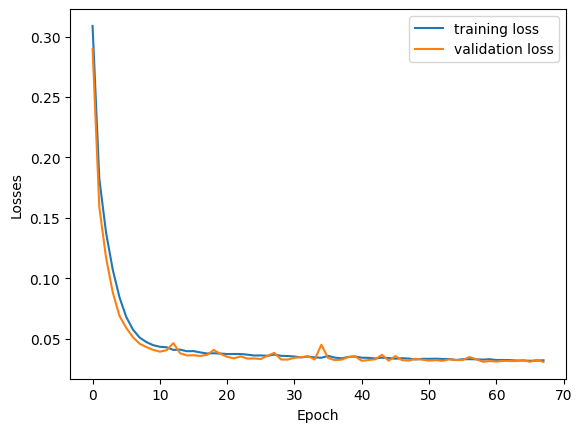

----------
Epoch 69/100
train Loss: 0.0312
val Loss: 0.0311


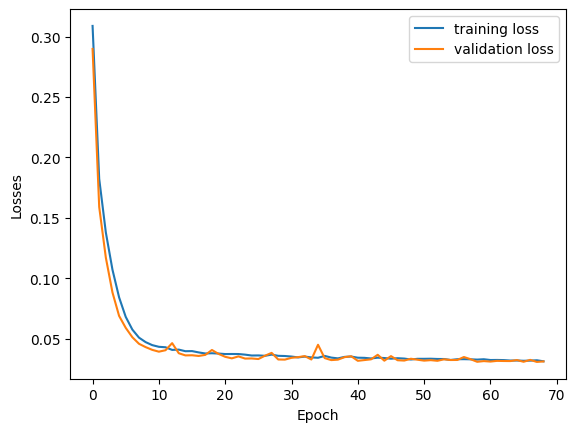

----------
Epoch 70/100
train Loss: 0.0312
val Loss: 0.0306
PASSED
Performance on test_set
Evaluation Loss: 0.0333


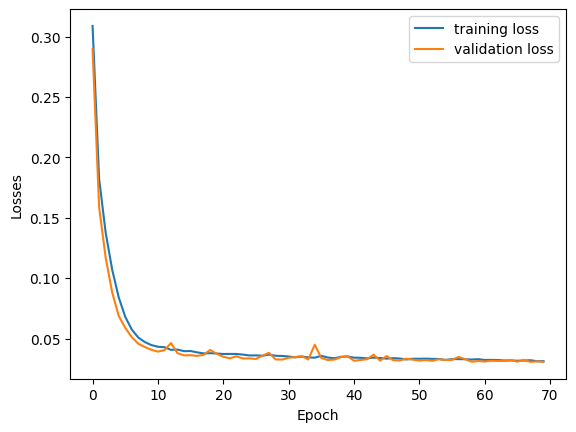

----------
Epoch 71/100
train Loss: 0.0315
val Loss: 0.0323


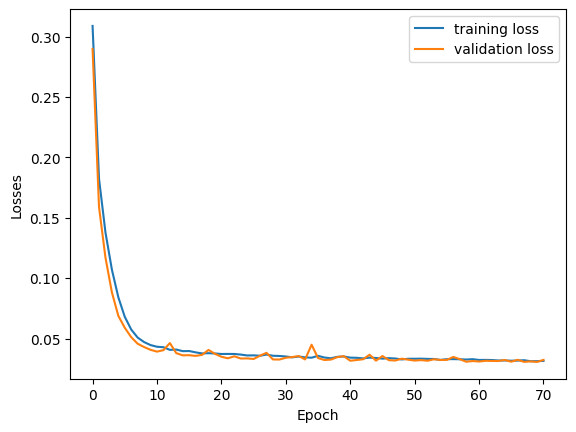

----------
Epoch 72/100
train Loss: 0.0313
val Loss: 0.0308


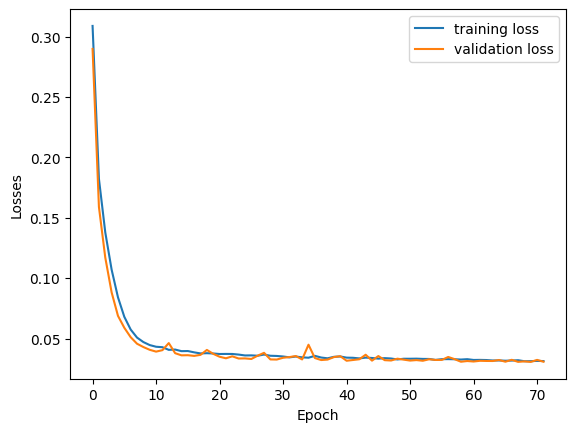

----------
Epoch 73/100
train Loss: 0.0314
val Loss: 0.0309


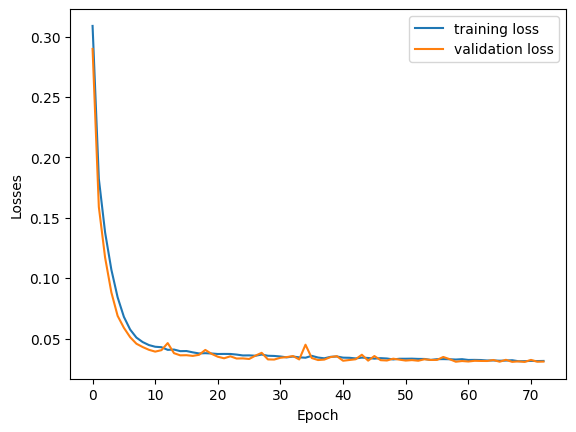

----------
Epoch 74/100
train Loss: 0.0309
val Loss: 0.0306


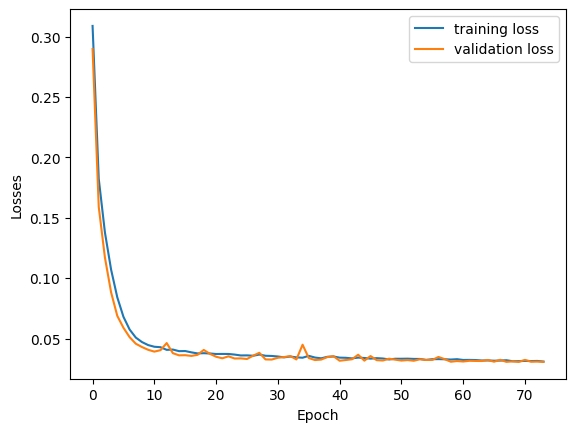

----------
Epoch 75/100


KeyboardInterrupt: 

In [139]:
model = train_model(model, criterion, l1_weight, l2_weight, optimizer, scheduler,
                       num_epochs=epochs, model_filename='NNmodel.pt')

In [119]:
eval_model(model, criterion, l1_weight, l2_weight, optimizer)

Evaluation Loss: 0.0335


0.03351303363249877

In [110]:
preds_df = predict(model, criterion, l1_weight, l2_weight, optimizer, 'real_test')

In [111]:
preds_df.to_csv('NN_submission.csv', index=False)